# U - Net
## Problem: 

Seismic data is collected using reflection seismology, or seismic reflection. The method requires a controlled seismic source of energy, such as compressed air or a seismic vibrator, and sensors record the reflection from rock interfaces within the subsurface. The recorded data is then processed to create a 3D view of earth’s interior. Reflection seismology is similar to X-ray, sonar and echolocation.

A seismic image is produced from imaging the reflection coming from rock boundaries. The seismic image shows the boundaries between different rock types. In theory, the strength of reflection is directly proportional to the difference in the physical properties on either sides of the interface. While seismic images show rock boundaries, they don't say much about the rock themselves; some rocks are easy to identify while some are difficult.

There are several areas of the world where there are vast quantities of salt in the subsurface. One of the challenges of seismic imaging is to identify the part of subsurface which is salt. Salt has characteristics that makes it both simple and hard to identify. Salt density is usually 2.14 g/cc which is lower than most surrounding rocks. The seismic velocity of salt is 4.5 km/sec, which is usually faster than its surrounding rocks. This difference creates a sharp reflection at the salt-sediment interface. Usually salt is an amorphous rock without much internal structure. This means that there is typically not much reflectivity inside the salt, unless there are sediments trapped inside it. The unusually high seismic velocity of salt can create problems with seismic imaging.

### Data
The data is a set of images chosen at various locations chosen at random in the subsurface. The images are 101 x 101 pixels and each pixel is classified as either salt or sediment. In addition to the seismic images, the depth of the imaged location is provided for each image. The goal of the competition is to segment regions that contain salt.

#### Source: 
https://www.kaggle.com/c/tgs-salt-identification-challenge


### Note: 
Accept the terms and download data from the above link

### Aim: 

Implement U-Net neural model architecture in keras to solve this problem.


In this, you are asked to segment salt deposits beneath the Earth’s surface. Given a set of seismic images that are 101 x 101 pixels each and each pixel we need to classify as either salt or sediment. Our goal is to segment regions that contain salt. A seismic image is produced from imaging the reflection coming from rock boundaries. The seismic image shows the boundaries between different rock types. 

### Broad Steps:

1. Download the dataset
2. Upload to Drive
3. Import from drive to colab
4. Load the images and create training data.
5. Build U-net Model
6. Train your model.
7. Check the validation accuracy and plot sample.

In [1]:
#Importing necessary libraries
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

#from tqdm import tqdm_notebook, tnrange
#from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout, Reshape
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, Callback
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.applications.mobilenet import MobileNet, preprocess_input
from keras.utils import Sequence
from keras.backend import epsilon

import tensorflow as tf
from tensorflow.keras.losses import binary_crossentropy

Using TensorFlow backend.


In [2]:
from segmentation_models import Unet
from segmentation_models.backbones import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score

C:\Users\birenderpanwar\Anaconda3\lib\site-packages\classification_models\resnext\__init__.py:4: UserWarning: Current ResNext models are deprecated, use keras.applications ResNeXt models
  warnings.warn('Current ResNext models are deprecated, '


In [54]:
#Mount drive
#from google.colab import drive
#drive.mount('/content/drive/')

# google drive not mapped as notebook is executed in local PC

### 1.Set your project path where you have your data and related files for this lab.

In [55]:
# setup project directory
#os.chdir('/content/drive/My Drive/AIML/lab_external_residency9')

project_path = "D:/my_learning/my_work/lab/lab_external_residency9/"
os.chdir(project_path)

In [56]:
os.getcwd()

'D:\\my_learning\\my_work\\lab\\lab_external_residency9'

### 2. Set the necessary parameters

## Setup

In [57]:
im_width = 128      #width of your train image
im_height = 128     #hight of your train image
#border =        
path_train = 'train/'   #Path for your train data

In [58]:
path_train

'train/'

# 3. Make directory for train data at in your project/lab folder.

Hint - use !mkdir function.

In [59]:
# create data directory
os.mkdir(path_train)

# 4. Extract your train images to the train directory you have just created above. 
train.zip and test.zip files available at your google drive/local system.

As a good practice - Upload or copy the data at your project path folder.

Make sure you are providing the right project_path.

In [60]:
#For simplicity we have added the required code here.
from zipfile import ZipFile

with ZipFile(project_path + 'train.zip', 'r') as zf:
  zf.extractall('train/')


In [7]:
#The train file have both images and masks with the same names_ids.

### 5. Get the list of names of images and masks and name the list imagelist and masklist.

Hint - Use os.listdir() funtions.

In [61]:
# prepare train dataset
imagelist = []
masklist = []

for file in os.listdir(os.path.join(path_train, "images")):
    imagelist.append('{}/{}'.format("images", file))
        
for file in os.listdir(os.path.join(path_train, "masks")):
    masklist.append('{}/{}'.format("masks", file))

In [62]:
#Test your list names by printing some of the names as given below.
print(imagelist[-1])
print(masklist[-1])
print(imagelist[10])
print(masklist[10])

images/fff987cdb3.png
masks/fff987cdb3.png
images/0108518d1e.png
masks/0108518d1e.png


# 6. Read and test your images and respective masks.

Hint -

import  matplotlib.pyplot as plt

import cv2

plt.imshow(cv2.imread('path of image'))

plt.imshow(cv2.imread('path of mask'))


In [63]:
import cv2

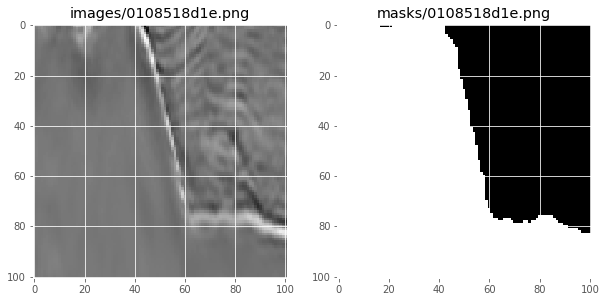

In [64]:
pos = 10  # images & mask position to read

fig, axs = plt.subplots(1,2,figsize=(10,10))
axs[0].set_title(imagelist[pos])
axs[0].imshow(cv2.imread(os.path.join(path_train,imagelist[pos]))) # read image
axs[1].set_title(masklist[pos])
axs[1].imshow(cv2.imread(os.path.join(path_train,masklist[pos]))) # read mask

plt.show()

# 7. Create your training data.

Hints - 

image_path = os.path.join(project_path +'path of your image directory' +n )

mask_path = os.path.join(project_path +'path of your mask directory'+n )

In [65]:
p = 12

size = (im_height, im_width)
img = cv2.imread(os.path.join(path_train,imagelist[p]), cv2.IMREAD_GRAYSCALE) # cv2.IMREAD_GRAYSCALE  
print(img.shape)
resize = cv2.resize(img,(im_height, im_width))
resize.shape

(101, 101)


(128, 128)

In [66]:
# Get and resize train images and masks.
def get_data():
    X = np.zeros(((len(imagelist), im_height, im_width, 1)), dtype=np.float32) # Create an array for image
    y = np.zeros(((len(masklist), im_height, im_width, 1)), dtype=np.float32) #Create an array for mask
    
    for n in imagelist: 
        k = imagelist.index(n)
        ##Add image_path
        image_path =  os.path.join(path_train,imagelist[k]) # /*** Add your code here***/
        ##Add mask_path
        mask_path =  os.path.join(path_train,masklist[k])                                                          
        
        # Load images and resize to (128,128,1)
        img = cv2.imread(image_path) # cv2.IMREAD_GRAYSCALE
        resized_img = np.resize(img, (im_height, im_width,1))
        
        # Load masks and resize to (128,128,1)
        img = cv2.imread(mask_path)
        resized_mask = np.resize(img,(im_height, im_width,1))
        
        # Save images
        #X[k] = resized_img.squeeze() / 255
        X[k] = resized_img/255
        y[k] = resized_mask/255
    print('Done!')    
    return X, y
    
X, y = get_data()

Done!


In [67]:
print("X shape", X.shape)
print("y shape", y.shape)

X shape (4000, 128, 128, 1)
y shape (4000, 128, 128, 1)


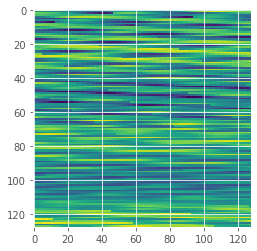

In [73]:
#Check the images
plt.imshow(X[1].squeeze())

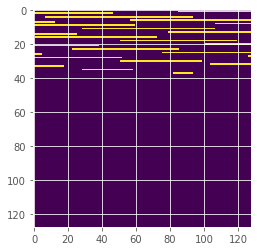

In [74]:
#Check the images
plt.imshow(y[1].squeeze())

In [75]:
# Split train and valid
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, random_state=2019)

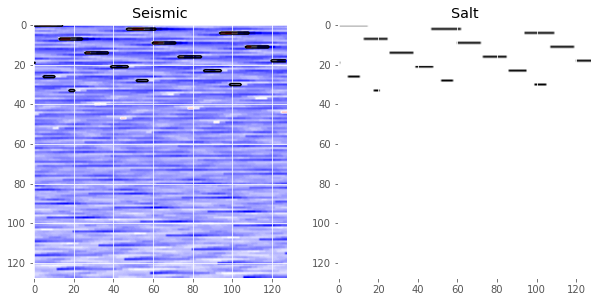

In [76]:
## Test your data whether it looks fine - Random check
import random 
# Check if training data looks all right
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0

fig, ax = plt.subplots(1, 2, figsize=(10, 10))

ax[0].imshow(X_train[ix, ..., 0], cmap='seismic', interpolation='bilinear')
if has_mask:
    ax[0].contour(y_train[ix].squeeze(), colors='k', levels=[0.5])
ax[0].set_title('Seismic')

ax[1].imshow(y_train[ix].squeeze(), interpolation='bilinear', cmap='gray')
ax[1].set_title('Salt');

### 8. Define loss and dice_coeff function.

In [77]:
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - tf.log(dice_coefficient(y_true, y_pred) + tf.keras.backend.epsilon())

In [78]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tf.keras.backend.epsilon())

### 9. Build and compile UNet Model for your data.

Hint - 
You can install and use segmentation models from this github repository.

#Install segmentation models

!pip install git+https://github.com/qubvel/segmentation_models

In [57]:
#Install segmentation models
!pip install git+https://github.com/qubvel/segmentation_models

  Cloning https://github.com/qubvel/segmentation_models to c:\users\birend~1\appdata\local\temp\pip-req-build-iwsdnbyd
  Stored in directory: C:\Users\BIREND~1\AppData\Local\Temp\pip-ephem-wheel-cache-yrw5mh3s\wheels\49\cf\46\cbb4bb64518c402aea99df9d466f1081450597e653256bbcf4
Successfully built segmentation-models


  Running command git clone -q https://github.com/qubvel/segmentation_models 'C:\Users\BIREND~1\AppData\Local\Temp\pip-req-build-iwsdnbyd'
  Running command git submodule update --init --recursive -q


In [79]:
#Import libraries
from segmentation_models import Unet
from segmentation_models.backbones import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score

In [80]:
#model = Unet(backbone_name='resnet34', encoder_weights=None, input_shape=(None, None, 1))
#compile your model by adding the parameters like optimizer, loss and metrics.

In [87]:
BACKBONE = 'resnet34'
preprocess_input = get_preprocessing(BACKBONE)

In [88]:
x_train = preprocess_input(X_train)
x_val = preprocess_input(X_valid)
print("x_train shape: ", x_train.shape)
print("x_val shape: ", x_val.shape)
print("y_train shape: ", y_train.shape)
print("y_valid shape: ", y_valid.shape)

x_train shape:  (3400, 128, 128, 1)
x_val shape:  (600, 128, 128, 1)
y_train shape:  (3400, 128, 128, 1)
y_valid shape:  (600, 128, 128, 1)


In [89]:
#Build your model 
from keras.layers import Reshape
N = x_train.shape[-1]

#base_model = Unet(backbone_name='resnet34', encoder_weights='imagenet')
base_model = Unet(backbone_name='resnet34', encoder_weights=None, input_shape=(None, None, 1))

In [90]:
# compile model
base_model.compile(optimizer='Adam', loss=loss, metrics=[dice_coefficient])

In [91]:
#Get the summary of your model
base_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, None, None, 1 0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, None, None, 1 3           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_35 (ZeroPadding2 (None, None, None, 1 0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, None, None, 6 3136        zero_padding2d_35[0][0]          
__________________________________________________________________________________________________
bn0 (Batch

### 10. Fit your model using model.fit function.
Hint - As it might take long time to run. Run it for only 1 or 2 epochs.

In [92]:
base_model.fit(
        x=x_train,
        y=y_train,
        batch_size=50,    
        epochs=2,
        validation_data=(x_val, y_valid)
    )

Train on 3400 samples, validate on 600 samples
Epoch 1/2
3400/3400 [==============================] - 1062s 312ms/step - loss: 1.6235 - dice_coefficient: 0.3700 - val_loss: 2.2539 - val_dice_coefficient: 0.3483
Epoch 2/2
3400/3400 [==============================] - 1039s 306ms/step - loss: 1.5108 - dice_coefficient: 0.3970 - val_loss: 2.2010 - val_dice_coefficient: 0.3557


### 11.Predict on val set using model.predict funtion and store in preds_val variable.



In [93]:
base_model.evaluate(x_val, y_valid, verbose=1)

600/600 [==============================] - 60s 101ms/step


[2.197070967356364, 0.35556178251902265]

In [94]:
# Predict on validation dataset
preds_val = base_model.predict(x_val, verbose=1)

600/600 [==============================] - 63s 105ms/step


In [95]:
#Get the threshold predictions to look at refined results.
preds_val_t = (preds_val > 0.5).astype(np.uint8)

In [96]:
#Plot a sample
def plot_sample(X, y, preds, binary_preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Seismic')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Salt')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Salt Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Salt Predicted binary');

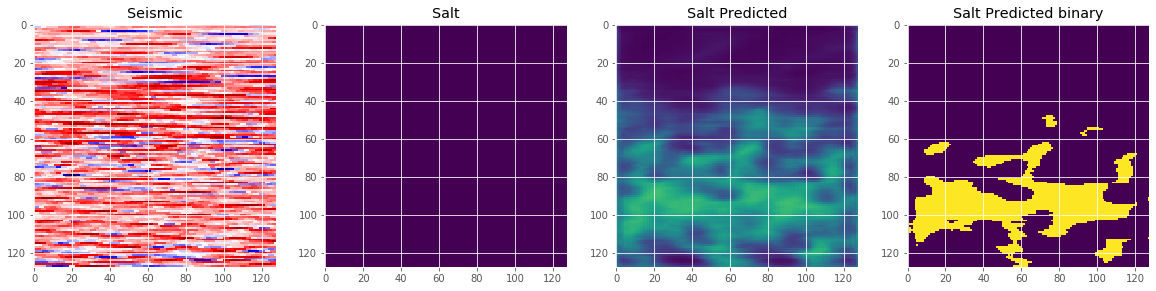

In [97]:
# Check if valid data looks all right
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=15)

If you are getting good results- Congratulations.
If you are not, try to explore what might be the reason.

# Text generation using a RNN

Given a sequence of words from this data, train a model to predict the next word in the sequence. Longer sequences of text can be generated by calling the model repeatedly.

**Mount your Google Drive**

In [0]:
# skipping this part as notebook is executed in local PC.. facing some issue with internet so running locally..

#Mount drive
#from google.colab import drive
#drive.mount('/content/drive/')

In [29]:
# setup project directory
#os.chdir('/content/drive/My Drive/AIML/lab_external_residency9')

project_path = "D:/my_learning/my_work/lab/lab_external_residency9/"
os.chdir(project_path)

In [32]:
os.getcwd()

'D:\\my_learning\\my_work\\lab\\lab_external_residency9'

### Import Keras and other libraries

In [3]:
# already imported many packages at the starting

# few more
import glob

from sklearn.utils import shuffle
import numpy as np

from keras.preprocessing.text import Tokenizer
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout, Embedding, Masking, Bidirectional
from keras.optimizers import Adam
from keras import backend

## Download data
Reference: Data is collected from http://www.gutenberg.org

For the lab purpose, you can load the dataset provided by Great Learning

In [36]:
data_path = 'data/'   #Path for your train data

# create data directory
os.mkdir(data_path)

In [37]:
# unzipping the directory 

from zipfile import ZipFile

with ZipFile('data.zip', 'r') as zf:
  zf.extractall()

### Load the Oscar Wilde dataset

Store all the ".txt" file names in a list

In [38]:
oscarlist = glob.glob("data/*.txt")
print("num of files: ", len(oscarlist))
oscarlist[0:5]

num of files:  31


['data\\A Critic in Pall Mall.txt',
 'data\\A House of Pomegranates.txt',
 'data\\A Woman of No Importance a play.txt',
 'data\\An Ideal Husband.txt',
 'data\\Charmides and Other Poems.txt']

### Read the data

Read contents of every file from the list and append the text in a new list

In [39]:
codetext = []
bookranges = []
for oscarfile in oscarlist:
    oscartext = open(oscarfile, "r", encoding="utf8")
    start = len(codetext)
    codetext.append(oscartext.read())
    end = len(codetext)
    bookranges.append({"start": start, "end": end, "name": oscarfile.rsplit("\\", 1)[-1]})
    oscartext.close()

In [40]:
codetext[0]

'\ufeffThe Project Gutenberg eBook, A Critic in Pall Mall, by Oscar Wilde, Edited\nby E. V. Lucas\n\n\nThis eBook is for the use of anyone anywhere at no cost and with\nalmost no restrictions whatsoever.  You may copy it, give it away or\nre-use it under the terms of the Project Gutenberg License included\nwith this eBook or online at www.gutenberg.org\n\n\n\n\n\nTitle: A Critic in Pall Mall\n\n\nAuthor: Oscar Wilde\n\nEditor: E. V. Lucas\n\nRelease Date: October 6, 2009  [eBook #30191]\n\nLanguage: English\n\nCharacter set encoding: UTF-8\n\n\n***START OF THE PROJECT GUTENBERG EBOOK A CRITIC IN PALL MALL***\n\n\nTranscribed from the 1919 Methuen & Co. Ltd. edition by David Price,\nemail ccx074@pglaf.org\n\n\n\n\n\n                                 A CRITIC\n                               IN PALL MALL\n\n\n                           BEING EXTRACTS FROM\n                         REVIEWS AND MISCELLANIES\n\n                                    BY\n                               OSCAR WILDE

In [41]:
bookranges[0:3]

[{'start': 0, 'end': 1, 'name': 'A Critic in Pall Mall.txt'},
 {'start': 1, 'end': 2, 'name': 'A House of Pomegranates.txt'},
 {'start': 2, 'end': 3, 'name': 'A Woman of No Importance a play.txt'}]

## Process the text
Initialize and fit the tokenizer

In [42]:
tokenizer = Tokenizer(lower=True, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(codetext)

### Vectorize the text

Before training, we need to map strings to a numerical representation. Create two lookup tables: one mapping words to numbers, and another for numbers to words.

In [43]:
word_idx = tokenizer.word_index
idx_word = tokenizer.index_word

Get the word count for every word and also get the total number of words.

In [44]:
word_counts = tokenizer.word_counts
num_words = len(word_idx) + 1

print("num of words: ", num_words)

num of words:  32839


Convert text to sequence of numbers

In [45]:
sequences = tokenizer.texts_to_sequences(codetext)

### Generate Features and Labels

In [46]:
features = []
labels = []

training_length = 50
# Iterate through the sequences of tokens
for seq in sequences:
    # Create multiple training examples from each sequence
    for i in range(training_length, training_length+300):
        # Extract the features and label
        extract = seq[i - training_length: i - training_length + 20]

        # Set the features and label
        features.append(extract[:-1])
        labels.append(extract[-1])

### The prediction task

Given a word, or a sequence of words, what is the most probable next word? This is the task we're training the model to perform. The input to the model will be a sequence of words, and we train the model to predict the output—the following word at each time step.

Since RNNs maintain an internal state that depends on the previously seen elements, given all the words computed until this moment, what is the next word?

### Generate training and testing data

In [47]:
from sklearn.utils import shuffle
import numpy as np

features, labels = shuffle(features, labels, random_state=1)

# Decide on number of samples for training
train_end = int(0.7 * len(labels))

train_features = np.array(features[:train_end])
valid_features = np.array(features[train_end:])

train_labels = labels[:train_end]
valid_labels = labels[train_end:]

# Convert to arrays
X_train, X_valid = np.array(train_features), np.array(valid_features)

# Using int8 for memory savings
y_train = np.zeros((len(train_labels), num_words), dtype=np.int8)
y_valid = np.zeros((len(valid_labels), num_words), dtype=np.int8)

# One hot encoding of labels
for example_index, word_index in enumerate(train_labels):
    y_train[example_index, word_index] = 1

for example_index, word_index in enumerate(valid_labels):
    y_valid[example_index, word_index] = 1

This is just to check the features and labels

In [48]:
for i, sequence in enumerate(X_train[:2]):
    text = []
#     print(i, sequence)
    for idx in sequence:
        text.append(idx_word[idx])
        
    print('Features: ' + ' '.join(text)+'\n')
    print('Label: ' + idx_word[np.argmax(y_train[i])] + '\n')

Features: 25 minutes act ii room in the duke’s palace 36 minutes act iii corridor in the duke’s palace 29

Label: minutes

Features: email ccx074 pglaf org note that later editions of de profundis contained more material the most complete editions are

Label: still



## Build The Model

Use `keras.Sequential` to define the model. For this simple example three layers are used to define our model:

* `keras.layers.Embedding`: The input layer. A trainable lookup table that will map the numbers of each character to a vector with `embedding_dim` dimensions;
* `keras.layers.LSTM`: A type of RNN with size `units=rnn_units` (You can also use a GRU layer here.)
* `keras.layers.Dense`: The output layer, with `num_words` outputs.

In [49]:
model = Sequential()

# Embedding layer
model.add(
    Embedding(
        input_dim=len(word_idx) + 1,
        output_dim=100,
        weights=None,
        trainable=True))

# Recurrent layer
model.add(
    LSTM(
        64, return_sequences=False, dropout=0.1,
        recurrent_dropout=0.1))

# Fully connected layer
model.add(Dense(64, activation='relu'))

# Dropout for regularization
model.add(Dropout(0.5))

# Output layer
model.add(Dense(num_words, activation='softmax'))

# Compile the model
model.compile(
    optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 100)         3283900   
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_5 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 32839)             2134535   
Total params: 5,464,835
Trainable params: 5,464,835
Non-trainable params: 0
_________________________________________________________________


For each word the model looks up the embedding, runs the LSTM one timestep with the embedding as input, and applies the dense layer to generate logits predicting the log-liklihood of the next word.

## Train the model

In [50]:
h = model.fit(X_train, y_train, epochs = 50, batch_size = 50, 
          verbose = 1)## Train the model

Epoch 1/50
6510/6510 [==============================] - 33s 5ms/step - loss: 8.2566 - acc: 0.0565
Epoch 2/50
6510/6510 [==============================] - 32s 5ms/step - loss: 6.7680 - acc: 0.0599
Epoch 3/50
6510/6510 [==============================] - 30s 5ms/step - loss: 6.4856 - acc: 0.0601
Epoch 4/50
6510/6510 [==============================] - 29s 4ms/step - loss: 6.3122 - acc: 0.0608
Epoch 5/50
6510/6510 [==============================] - 31s 5ms/step - loss: 6.1706 - acc: 0.0601
Epoch 6/50
6510/6510 [==============================] - 29s 4ms/step - loss: 6.0547 - acc: 0.0648
Epoch 7/50
6510/6510 [==============================] - 29s 4ms/step - loss: 5.9283 - acc: 0.0664
Epoch 8/50
6510/6510 [==============================] - 28s 4ms/step - loss: 5.8110 - acc: 0.0705
Epoch 9/50
6510/6510 [==============================] - 30s 5ms/step - loss: 5.7152 - acc: 0.0719
Epoch 10/50
6510/6510 [==============================] - 29s 4ms/step - loss: 5.6133 - acc: 0.0776
Epoch 11/50
6510/65

### Save Model

In [51]:
# save the model to file
model.save('models/model_oscar.h5')

## If you have already trained the model and saved it, you can load a pretrained model

In [23]:
# load the model
model = load_model('models/model_oscar.h5')

### Note: After loading the model run  model.fit()  to continue training form there, if required.

In [25]:
model.fit(X_train, y_train, batch_size=50, epochs=2)

Epoch 1/2
6510/6510 [==============================] - 29s 4ms/step - loss: 6.3695 - acc: 0.0587
Epoch 2/2
6510/6510 [==============================] - 28s 4ms/step - loss: 6.2231 - acc: 0.0578


## Evaluation

In [52]:
print(model.evaluate(X_train, y_train, batch_size = 20))
print('\nModel Performance: Log Loss and Accuracy on validation data')
print(model.evaluate(X_valid, y_valid, batch_size = 20))

6510/6510 [==============================] - 36s 5ms/step
[1.389055918530202, 0.7204301075268817]

Model Performance: Log Loss and Accuracy on validation data
2790/2790 [==============================] - 14s 5ms/step
[6.726879432637205, 0.358064516470851]


## Generate text

In [53]:
seed_length=50
new_words=50
diversity=1
n_gen=1

import random

# Choose a random sequence
seq = random.choice(sequences)

# print seq

# Choose a random starting point
seed_idx = random.randint(0, len(seq) - seed_length - 10)
# Ending index for seed
end_idx = seed_idx + seed_length

gen_list = []

for n in range(n_gen):
    # Extract the seed sequence
    seed = seq[seed_idx:end_idx]
    original_sequence = [idx_word[i] for i in seed]
    generated = seed[:] + ['#']

    # Find the actual entire sequence
    actual = generated[:] + seq[end_idx:end_idx + new_words]
        
    # Keep adding new words
    for i in range(new_words):

        # Make a prediction from the seed
        preds = model.predict(np.array(seed).reshape(1, -1))[0].astype(np.float64)

        # Diversify
        preds = np.log(preds) / diversity
        exp_preds = np.exp(preds)

        # Softmax
        preds = exp_preds / sum(exp_preds)

        # Choose the next word
        probas = np.random.multinomial(1, preds, 1)[0]

        next_idx = np.argmax(probas)

        # New seed adds on old word
        #             seed = seed[1:] + [next_idx]
        seed += [next_idx]
        generated.append(next_idx)
    # Showing generated and actual abstract
    n = []

    for i in generated:
        n.append(idx_word.get(i, '< --- >'))

    gen_list.append(n)

a = []

for i in actual:
    a.append(idx_word.get(i, '< --- >'))

a = a[seed_length:]

gen_list = [gen[seed_length:seed_length + len(a)] for gen in gen_list]

print('Original Sequence: \n'+' '.join(original_sequence))
print("\n")
# print(gen_list)
print('Generated Sequence: \n'+' '.join(gen_list[0][1:]))
# print(a)

C:\Users\birenderpanwar\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in log


Original Sequence: 
a user who notifies you in writing or by e mail within 30 days of receipt that s he does not agree to the terms of the full project gutenberg tm license you must require such a user to return or destroy all copies of the works possessed in a


Generated Sequence: 
belong to in the change after le pontefract lady bracknell lady fisherman of his ballad of prison john of wilde copies your cabinet at art in spite of russia language english ebook 3 vera room to all lady only that salomé as yet upon a persons it is the duke’s
